# Analysis of General Healthcare Access in Kenya, Nairobi
> Note: This notebook requires the [environment dependencies](requirements.txt) to be installed
> as well as either an [openrouteservice API key](https://openrouteservice.org/dev/#/signup) or a local instance of the ORS server.

## Model Summary:

This notebook provides the means to generate a dataset that is described in the [model documentation](../Nairobi-v2/dataset-interpretability.md).

## Workflow Summary:

The notebook gives an overview of the distribution of centres offering general healthcare in the city. Open source data from OpenStreetMap and tools (such as the openrouteservice) were used to create accessibility measures. Spatial analysis and other data analytics functions led to generating outputs within the 100x100m grid cells that categorised them into three levels: low, medium, and high.

* **Preprocessing**: Get data for general healthcare facilities.
* **Analysis for Offer**:
    * Filter or classify general healthcare facilities based on discussed criteria.
    * Visualise general healthcare faccilities in their categories.
* **Analysis for Accessibility**:
    * Compute isochrones to facilities using openrouteservice API or other routing services.
    * Generate areas for low, medium and high categories based on discussed criteria.
* **Analysis for Demmand**:
    * Derive socio-economic descriptors based on discussed criteria.

* **Result**: Generate results as GIS-compatible files.


### Datasets and Tools:
* [Shapefile of district boundaries](https://data.humdata.org/dataset/kenya-admin-level-3-wards) - Admin Level 3 (data from Humanitarian Data Exchange, 25/11/2015)
* [openrouteservice](https://openrouteservice.org/) - generate isochrones on the OpenStreetMap road network

#  Workflow

Make sure you have the required packages installed. You can install them using pip:

```bash
pip install -r requirements.txt
```

This study integrates various Python geospatial analysis libraries and packages to support spatial data processing, visualization, and isochrone generation. The os module is used to interact with the operating system, managing file paths and reading environment variables such as API keys. folium library along with its MarkerCluster plugin, facilitates the creation of interactive maps for visualizing large-scale geospatial data. The openrouteservice.client serves as an interface to the OpenRouteService API, enabling the extraction of isochrones. pandas library for data analysis, provides functions for analyzing, cleaning, exploring, and manipulating data, while fiona supports reading and writing real-world data using multi-layered GIS formats, such as shapefiles. The shapely package is employed for the manipulation and analysis of planar geometric objects.

## Setting up the virtual environment
```bash
# Create a new virtual environment
python -m venv .venv
activate .venv/bin/activate
pip install -r requirements.txt
```

## To run your notebook in VS Code

```bash
pip install -U ipykernel
python -m ipykernel install --user --name=.venv
```

In [17]:
import geopandas as gpd
import os
import numpy as np
import pandas as pd

import openrouteservice
from dotenv import load_dotenv
import folium
from folium.plugins import MarkerCluster

import rasterio
from rasterio.mask import mask
import ast

from pathlib import Path
from shapely.geometry import Polygon
from shapely.geometry import shape, mapping
from shapely.geometry import Point

import requests
from math import *
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time

### Setting up the public API Key from OpenRouteService
In this study, users must obtain an ORS Matrix API key from the [OpenRouteService](https://openrouteservice.org/) platform and subsequently interacted with the OpenRouteService API through the instantiation of the OpenRouteService client. This is the OpenRouteService [API documentation](https://openrouteservice.org/dev/#/api-docs/introduction) for ORS Core-Version 9.0.0. 

Generate a [API Key](https://openrouteservice.org/dev/#/home?tab=1) (Token) it is necessary to sign up at the OpenRouteService dashboard by using your E-mail address or sign up with your GitHub. After logging in, go to the Dashboard by clicking on your profile icon and navigate to the API Keys section. Click "Create API Key" to generate a free key and then choose a service plan (the free plan has limited requests per day). Copy the API Key and store it securely. 

OpenRouteService primarily uses API keys for authentication. However, if a token is required for certain endpoints, you can send a request with your API key in the Authorization header. This process facilitated various geospatial analysis functions, including isochrone generation.

### Using an ORS API Key
Make sure you have a .env file in the root directory with the following content:
```bash
    OPENROUTESERVICE_API_KEY='your_api_key'
```

In [ ]:
# %%
# Read the api key from the .env file
%load_ext dotenv
%dotenv
api_key = os.getenv('OPENROUTESERVICE_API_KEY')
ors = openrouteservice.Client(key=api_key)

### Setting up relevant processing folders

There are different data sources used across the notebook. To handle these data sets, it is recommended to use three directories for input, temp and output data. Some of the files are related to healthcare facilities, population data. The healthcare facilities data was extracted by our team of experts through web scraping from the [Kenya Master Health Facility Registry (KMHFR)](https://kmhfr.health.go.ke/public/facilities).

Despite being official, administrative boundaries may not reflect the actual patterns of human settlement or economic activity. Therefore, the team used the Functional Urban Area (FUA) as a complementary definition of the study areas. The FUA is defined by [the Joint Research Centre of the European Commission](https://commission.europa.eu/about/departments-and-executive-agencies/joint-research-centre_en) as the actual urban sprawl and human activities, encompassing the core city and economically or socially integrated surrounding regions. The FUA was obtained from [the Global Human Settlement Layer (GHSL) ](https://human-settlement.emergency.copernicus.eu/)dataset, which provides spatial data for functional urban areas worldwide. 

The following datasets are considered as input data for the analysis:


* [Datasets of health facilities](../scripts/Nairobi/data-inputs/nairobi_healthcare_facilities.geojson)
* [Study Area](../../../docs/study-areas/grid-boundary-nairobi.gpkg) defined by the IDEAMAPS team

In [18]:
# Set paths to access Kano data
# Define directories
data_inputs = '../scripts/Nairobi/data-inputs/'
data_temp = '../scripts/Nairobi/data-temp/'
model_outputs = '../Nairobi-v2/'

## Data Collection

### 1.1 Study area and Administrative level 2

In [3]:
study_area = gpd.read_file(data_inputs + 'grid-boundary-nairobi.gpkg')
districts = gpd.read_file(data_inputs + 'administrative_level2.geojson')

In [8]:
# Adding a grid_id to the gridcells in the study area
study_area['grid_id'] = range(len(study_area))

In [9]:
study_area

,latitude,longitude,lat_min,lat_max,lon_min,lon_max,geometry,grid_id
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694...",0
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694...",1
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694...",2
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694...",3
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694...",4
...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7...",110458
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7...",110459
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7...",110460
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7...",110461


### 1.2 General Healthcare Facilities

Healthcare facilities data were scraped from the [Kenya Master Health Facility Registry (KMHFR)](https://kmhfr.health.go.ke/public/facilities) which is an application with all health facilities and community units in Kenya, with validation and classification guidance provided by local domain experts. For general healthcare model, we focused on facilities classified as publicly ownership and primary level. Public health facilities are labeled as MoH (Ministry of Health). Primary care facilities in Kenya would be Level 2 (Dispensaries and Clinics), and Level 3 (Health Centers). Other higher levels still offer primary healthcare but are more focused on comprehensive healthcare. However, we consider including all levels in the model since each contributes to the delivery of primary healthcare. 

In [13]:
healthcare_facilities = pd.read_csv(data_inputs + 'healthcare_facilities_Nairobi.csv')
healthcare_facilities

,fid,field_1,Admin1,Facility_name,Facility_type,Ownership,Latitude,Longitude,LL_source,Sub County,...,Postnatal Care Services,Radiology and Imaging,Rehabilitation Services,Renal Services,Services For Gender Based Violence Survivors,Specialized In-Patient Services,Specialised Outpatient care,Theatre Services,Tuberculosis Diagnosis and Treatments,Youth Friendly Services
0,1031,Kenya,Nairobi,The Co-Operative University College of Kenya D...,Dispensary,Ministry of Health,-1.36643,36.72909,KMHFR,Lang'ata,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,634,Kenya,Nairobi,Blessed Medicare Centre,Medical Clinic,Private Practice,-1.31566,36.88943,KMHFR,Embakasi South,...,Yes,No,No,No,No,No,No,No,No,No
2,562,Kenya,Nairobi,Jkia Health Centre,Basic Health Centre,Ministry of Health,-1.32882,36.92517,KMHFR,Embakasi East,...,No,No,No,No,No,No,No,No,No,No
3,1062,Kenya,Nairobi,The Mesu Langata Family Health Care Limited,Medical Clinic,Private Practice,-1.32154,36.79910,KMHFR,Lang'ata,...,No,No,No,No,No,No,No,No,No,No
4,620,Kenya,Nairobi,Catholic Dispensary Kariobangi,Dispensary,Faith Based Organization,-1.25775,36.87993,KMHFR,Embakasi North,...,Yes,No,No,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,529,Kenya,Nairobi,Hope World Wide Kenya Tassia,Medical Clinic,Non-Governmental Organization,-1.31659,36.89773,KMHFR,Embakasi East,...,No,No,No,No,No,No,No,No,No,No
1117,905,Kenya,Nairobi,Brooks of Cherith (Upper Hill),Primary Care Hospital,Private Practice,-1.30263,36.81904,KMHFR,Kibra,...,No,No,No,No,No,No,No,No,No,No
1118,712,Kenya,Nairobi,Bhesp Mowlem Dice Clinic,Medical Clinic,Non-Governmental Organization,-1.25750,36.90199,KMHFR,Embakasi West,...,No,No,No,No,Yes,No,No,No,No,No
1119,740,Kenya,Nairobi,Innercore Medical Clinic,Medical Clinic,Private Practice,-1.28259,36.88761,KMHFR,Embakasi West,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#  Extract latitude and longitude from the 'lat_long' column
# healthcare_facilities = healthcare_facilities[healthcare_facilities['lat_long'].notna()]
# healthcare_facilities[['latitude', 'longitude']] = healthcare_facilities['lat_long'].apply(
    # lambda x: pd.Series(ast.literal_eval(x)))

In [14]:
# Filter healthcare facilities for Ministry of Health public ownership
healthcare_facilities = healthcare_facilities[
    (healthcare_facilities['Ownership'] == 'Ministry of Health')]

In [15]:
geometry = [Point(xy) for xy in zip(healthcare_facilities['Longitude'], healthcare_facilities['Latitude'])]
healthcare_facilities_nairobi = gpd.GeoDataFrame(healthcare_facilities, geometry=geometry, crs='EPSG:4326')

In [16]:
columns_to_keep = ['field_1','Admin1','Ward','Facility_name','Facility_type', 'Ownership', 'Level', 'Operating time','Latitude','Longitude', 'geometry']
healthcare_facilities_nairobi = healthcare_facilities_nairobi[columns_to_keep]

In [17]:
healthcare_facilities_nairobi = healthcare_facilities_nairobi.reset_index(drop=True)
healthcare_facilities_nairobi['hcf_id'] = healthcare_facilities_nairobi.index + 1
healthcare_facilities_nairobi

,field_1,Admin1,Ward,Facility_name,Facility_type,Ownership,Level,Operating time,Latitude,Longitude,geometry,hcf_id
0,Kenya,Nairobi,Karen,The Co-Operative University College of Kenya D...,Dispensary,Ministry of Health,2,24 hours,-1.36643,36.72909,POINT (36.72909 -1.36643),1
1,Kenya,Nairobi,Embakasi,Jkia Health Centre,Basic Health Centre,Ministry of Health,3,24 hours + Weekends,-1.32882,36.92517,POINT (36.92517 -1.32882),2
2,Kenya,Nairobi,Maringo/Hamza,Ofafa I Clinic,Dispensary,Ministry of Health,2,24 hours,-1.29587,36.86623,POINT (36.86623 -1.29587),3
3,Kenya,Nairobi,Ruaraka,Redemeed Health Centre,Basic Health Centre,Ministry of Health,3,24 hours + Weekends,-1.24425,36.88508,POINT (36.88508 -1.24425),4
4,Kenya,Nairobi,Viwandani,Lunga Lunga Health Centre,Basic Health Centre,Ministry of Health,3,24 hours,-1.30669,36.86778,POINT (36.86778 -1.30669),5
...,...,...,...,...,...,...,...,...,...,...,...,...
110,Kenya,Nairobi,Woodley/Kenyatta Golf Course,National Parasitology and NTD Reference Lab,Laboratory,Ministry of Health,2,24 hours,-1.30573,36.80677,POINT (36.80677 -1.30573),111
111,Kenya,Nairobi,Kasarani,Mwiki Health Centre,Comprehensive Health Centre,Ministry of Health,3,24 hours + Weekends,-1.22807,36.93311,POINT (36.93311 -1.22807),112
112,Kenya,Nairobi,kasarani,Kenya Institute Of Special Education Dispensary,Dispensary,Ministry of Health,2,24 hours + Weekends,-1.22762,36.89548,POINT (36.89548 -1.22762),113
113,Kenya,Nairobi,Mountain view,Gichagi Dispensary,Dispensary,Ministry of Health,3,24 hours,-1.27334,36.74316,POINT (36.74316 -1.27334),114


### Create district dictionary and facilities dictionary
In conducting geospatial analysis, we created dictionaries containing district information and healthcare facility information to achieve efficient data management and subsequent analysis.

In [18]:
# these files will be generated during processing
isochrones_car_filename = data_temp + 'iso_union_car.shp'
isochrones_car_per_district_filename = data_temp + 'iso_car_per_district.shp'
isochrones_foot_filename = data_temp + 'iso_union_foot.shp'
isochrones_foot_per_district_filename = data_temp + 'iso_foot_per_district.shp'

# final file with all generated information
output_file = data_temp + 'districts_final.geojson'

In [19]:
districts

,IEBC_WARDS,COUNT,FIRST_PROV,FIRST_DIST,FIRST_DIVI,PCODE,STATUS,NO,SHAPE_1,STATUS_1,geometry
0,Got Kachola,5,Nyanza,Migori,Nyatike,KE0001,None,1287.0,Polygon,done,"MULTIPOLYGON (((34.27875 -1.02529, 34.27888 -1..."
1,Kachieng',8,Nyanza,Migori,Karungu,KE0003,None,1282.0,Polygon,None,"MULTIPOLYGON (((33.92791 -0.85329, 33.9268 -0...."
2,Kendu Bay Town,6,Nyanza,Rachuonyo,East Karachuonyo,KE0004,None,1236.0,Polygon,None,"MULTIPOLYGON (((34.69128 -0.40168, 34.69099 -0..."
3,Abakaile,2,North Eastern,Garissa,Dadaab,KE0005,None,151.0,Polygon,None,"MULTIPOLYGON (((39.91378 0.45627, 39.9146 0.45..."
4,Abogeta East,10,Eastern,Meru Central,Abogeta,KE0006,None,293.0,Polygon,None,"MULTIPOLYGON (((37.71729 -0.11334, 37.71759 -0..."
...,...,...,...,...,...,...,...,...,...,...,...
1420,Ziwa,4,Rift Valley,Uasin Gishu,Soy,KE1422,None,703.0,Polygon,None,"MULTIPOLYGON (((35.24938 0.88586, 35.24968 0.8..."
1421,Ziwani/Kariokor,1,Nairobi,Nairobi,Central,KE1423,None,1442.0,Polygon,None,"MULTIPOLYGON (((36.84377 -1.27789, 36.84366 -1..."
1422,Kabuoch South/Pala,3,Nyanza,Homa Bay,Riana,KE0002,None,1249.0,Polygon,None,"MULTIPOLYGON (((34.42029 -0.78491, 34.41992 -0..."
1423,Homa Bay Central,3,Nyanza,Homa Bay,Asego,KE0329,None,1241.0,Polygon,None,"MULTIPOLYGON (((34.46948 -0.54242, 34.47351 -0..."


In [20]:
districts_dictionary = {}
for _, feature in districts.iterrows():
    district_id = feature['PCODE']
    districts_dictionary[district_id] = {
        'District Name': feature['FIRST_DIST'],
        'geometry': feature['geometry']
    }
print(f'created dictionary for {len(districts_dictionary)} districts')

facilities_dictionary = {}
for _, feature in healthcare_facilities_nairobi.iterrows():
    facility_id = int(feature['hcf_id'])
    facilities_dictionary[facility_id] = {
        'geometry': feature['geometry']
    }
print(f'created dictionary for {len(facilities_dictionary)} facilities')

created dictionary for 1423 districts
created dictionary for 115 facilities


### An overview and look at a map of the districts and health facilities
First a map were created with [Folium](https://python-visualization.github.io/folium/latest/) to visualize data manipulated in Python. The boundaries of the districts as well as the health sites were given as shapefiles, which were printed on the map. 

In [21]:
map_outline = folium.Map(tiles='Stamen Toner', location=[-18.812718, 46.713867], zoom_start=5, attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors')

# Import health facilities
cluster = MarkerCluster().add_to(map_outline)  # To cluster hospitals

for facility_id in facilities_dictionary:
    folium.Marker(list(reversed(facilities_dictionary[facility_id]['geometry'].coords[0]))).add_to(cluster)

# Import district boundaries
district_simp = []  # Initialize the list
for district_id in districts_dictionary:
    geom = shape(districts_dictionary[district_id]['geometry'])
    # we simplify the geometry just for the purpose of visualisation
    # be aware that some browsers e.g. chrome might fail to render the entire map if there are to many coordinates
    simp_geom = geom.simplify(0.005, preserve_topology=False)
    simp_coord = mapping(simp_geom)
    folium.GeoJson(simp_coord).add_to(map_outline)
    district_simp.append(simp_coord)

#change to variable
map_outline.save(os.path.join(data_temp + 'healthcare_facilities_overview.html'))
map_outline

## Analysis
We will follow these steps:
* Get Isochrones from openrouteservice
* Perform Spatial Join
* Save output as GeoPackage file and CSV file

### Get Isochrones from OpenRouteService
Due to the limited road networks in the slum areas of these three cities, the accessibility of hospitals within a 10-minute range is of significant concern. Therefore, isochrones with 1km walk range and 3.3km car drive range around each hospital were created with the open source tool [OpenRouteService](https://openrouteservice.org/). This might take several minutes depending on the number of health facilities.

In [22]:
print(healthcare_facilities_nairobi['Level'].unique())

[2 3 5 6 4]


In [23]:
healthcare_facilities_nairobi['Level'] = healthcare_facilities_nairobi['Level'].astype(str)

healthcare_facilities_nairobi['Level'] = np.where(
    healthcare_facilities_nairobi['Level'].isin(['2', '3']), # facility level 2 and 3 in Nairobi are treated as 'Primary' facilities
    'Primary',
    'Primary & Comprehensive'
)

In [24]:
healthcare_facilities_nairobi

,field_1,Admin1,Ward,Facility_name,Facility_type,Ownership,Level,Operating time,Latitude,Longitude,geometry,hcf_id
0,Kenya,Nairobi,Karen,The Co-Operative University College of Kenya D...,Dispensary,Ministry of Health,Primary,24 hours,-1.36643,36.72909,POINT (36.72909 -1.36643),1
1,Kenya,Nairobi,Embakasi,Jkia Health Centre,Basic Health Centre,Ministry of Health,Primary,24 hours + Weekends,-1.32882,36.92517,POINT (36.92517 -1.32882),2
2,Kenya,Nairobi,Maringo/Hamza,Ofafa I Clinic,Dispensary,Ministry of Health,Primary,24 hours,-1.29587,36.86623,POINT (36.86623 -1.29587),3
3,Kenya,Nairobi,Ruaraka,Redemeed Health Centre,Basic Health Centre,Ministry of Health,Primary,24 hours + Weekends,-1.24425,36.88508,POINT (36.88508 -1.24425),4
4,Kenya,Nairobi,Viwandani,Lunga Lunga Health Centre,Basic Health Centre,Ministry of Health,Primary,24 hours,-1.30669,36.86778,POINT (36.86778 -1.30669),5
...,...,...,...,...,...,...,...,...,...,...,...,...
110,Kenya,Nairobi,Woodley/Kenyatta Golf Course,National Parasitology and NTD Reference Lab,Laboratory,Ministry of Health,Primary,24 hours,-1.30573,36.80677,POINT (36.80677 -1.30573),111
111,Kenya,Nairobi,Kasarani,Mwiki Health Centre,Comprehensive Health Centre,Ministry of Health,Primary,24 hours + Weekends,-1.22807,36.93311,POINT (36.93311 -1.22807),112
112,Kenya,Nairobi,kasarani,Kenya Institute Of Special Education Dispensary,Dispensary,Ministry of Health,Primary,24 hours + Weekends,-1.22762,36.89548,POINT (36.89548 -1.22762),113
113,Kenya,Nairobi,Mountain view,Gichagi Dispensary,Dispensary,Ministry of Health,Primary,24 hours,-1.27334,36.74316,POINT (36.74316 -1.27334),114


In [50]:
healthcare_facilities_nairobi.to_file(data_inputs + 'healthcare_facilities.geojson', driver='GeoJSON')

### 1. Calculating the isochrones for 3.3km driving

In [30]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Primary & Comprehensive": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = healthcare_facilities_nairobi[healthcare_facilities_nairobi["Level"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["Facility_name"]

        if not isinstance(loc, Point):
            print(f"Invalid geometry for: {facility_name} — Skipping")
            continue

        coordinates = [loc.x, loc.y]
        
        # Prepare request parameters
        try:
            iso_params = {
                "locations": [coordinates],
                "profile": "driving-car",
                "range_type": "distance",
                "range": [3300], # 3.3 km isochrone
            }
            
            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for k, v in properties.items():
                    if isinstance(v, list):
                        properties[k] = ', '.join(map(str, v))
                
                 # Add a new column for the category
                properties.update({
                    "facility_level": category,
                    "facility_id": facility_id,
                    "facility_name": facility_name
                })

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            # Use this sleep when using the OSR instance hosted by HeiGIT
            time.sleep(1.5)

            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {facility_name}: {e}")


In [31]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'facility_level' is a string column
    iso_gdf["facility_level"] = iso_gdf["facility_level"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_3_3km_car.gpkg', driver="GPKG")
    

### 2. Calculating the isochrones for 1km walking

In [32]:
all_features = []

# Initialize request counter
request_counter = 0

# Create a dictionary to store isochrones by category
isochrones_by_category = {
    "Primary": [],
    "Primary & Comprehensive": []
}

# Loop through each category
for category in isochrones_by_category.keys():
    # Filter facilities by category
    group = healthcare_facilities_nairobi[healthcare_facilities_nairobi["Level"] == category]

    for _, row in group.iterrows():
        loc = row["geometry"]
        facility_id = row["hcf_id"]
        facility_name = row["Facility_name"]

        if not isinstance(loc, Point):
            print(f"Invalid geometry for: {facility_name} — Skipping")
            continue

        coordinates = [loc.x, loc.y]
        
        # Prepare request parameters
        try:
            iso_params = {
                "locations": [coordinates],
                "profile": "foot-walking",
                "range_type": "distance",
                "range": [1000], # 1km isochrone
            }
            
            # Request isochrone from ORS
            isochrone = ors.isochrones(**iso_params)

            for feature in isochrone['features']:
                properties = feature['properties']

                # Convert list fields to strings if needed
                for k, v in properties.items():
                    if isinstance(v, list):
                        properties[k] = ', '.join(map(str, v))
                
                 # Add a new column for the category
                properties.update({
                    "facility_level": category,
                    "facility_id": facility_id,
                    "facility_name": facility_name
                })

                all_features.append({
                    'geometry': feature['geometry'],
                    'properties': properties
                })

            # Handle rate limiting
            request_counter += 1
            # Use this sleep when using the OSR instance hosted by HeiGIT
            time.sleep(1.5)

            if request_counter > 2500:
                print("Reached max request threshold.")
                break

        except Exception as e:
            print(f"Request failed for {facility_name}: {e}")


In [33]:
# Convert to GeoDataFrame if there are valid features
if all_features:
    iso_gdf = gpd.GeoDataFrame.from_features(all_features, crs="EPSG:4326")

    # Ensure 'combination' is a string column
    iso_gdf["facility_level"] = iso_gdf["facility_level"].astype(str)
    iso_gdf["facility_id"] = iso_gdf["facility_id"].astype(str)
    iso_gdf["facility_name"] = iso_gdf["facility_name"].astype(str)

    # Save to a single GeoPackage file
    iso_gdf.to_file(data_temp + 'General_healthcare_iso_1km_walking.gpkg', driver="GPKG")

## Spatial joins for the grid and isochrone layers using geopandas
This study employed the GeoPandas library to perform a spatial join between isochrone data and 100x100m grid cells, which allowed for the analysis and evaluation of accessibility for each grid cell within the study area in these three cities, across different time intervals (specifically by walking or driving). Accessibility was classified as three levels: high, medium and low. The analysis results were exported in GeoPackage format to ensure both the persistent storage and reusability of the data. Additionally, all spatial datasets were maintained in the same coordinate reference system (EPSG:4326), which ensured consistency and accuracy in the spatial joins and subsequent analyses.

In [1]:
# Read grid cells and isochrones from the GeoPackage file
# Ensure both GeoDataFrames have the same CRS (EPSG:4326)
isochrones_foot_gdf = gpd.read_file(data_temp + 'General_healthcare_iso_1km_walking.gpkg')
isochrones_car_gdf = gpd.read_file(data_temp + 'General_healthcare_iso_3_3km_car.gpkg')

NameError: name 'gpd' is not defined

### Aggregating the isochrone results to the grid cell level using geopandas

In [35]:
target_crs = "EPSG:4326"
isochrones_foot_gdf = isochrones_foot_gdf.to_crs(target_crs)
isochrones_car_gdf = isochrones_car_gdf.to_crs(target_crs)
study_area = study_area.to_crs(target_crs)

Spatial join to count the number of isochrones for 1km walking distance falling in each grid cell


In [36]:
joined = gpd.sjoin(isochrones_foot_gdf, study_area, how="inner", predicate="intersects")

isochrone_count = joined.groupby("grid_id").size().reset_index(name='iso_walk_1k_count')

study_area["iso_walk_1k_count"] = 0
study_area.loc[isochrone_count["grid_id"], "iso_walk_1k_count"] = isochrone_count["iso_walk_1k_count"].values

study_area


,latitude,longitude,lat_min,lat_max,lon_min,lon_max,geometry,grid_id,iso_walk_1k_count
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694...",0,0
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694...",1,0
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694...",2,0
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694...",3,0
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694...",4,0
...,...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7...",110458,0
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7...",110459,0
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7...",110460,0
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7...",110461,0


Spatial join to count the number of isochrones for 3.3km driving distance falling in each grid cell. Values are appended to the previously created grid cells.

In [37]:
joined = gpd.sjoin(isochrones_car_gdf, study_area, how="inner", predicate="intersects")

isochrone_count = joined.groupby("grid_id").size().reset_index(name='iso_3_3km_count')

study_area["iso_3_3km_count"] = 0
study_area.loc[isochrone_count["grid_id"], "iso_3_3km_count"] = isochrone_count["iso_3_3km_count"].values

study_area


,latitude,longitude,lat_min,lat_max,lon_min,lon_max,geometry,grid_id,iso_walk_1k_count,iso_3_3km_count
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694...",0,0,0
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694...",1,0,0
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694...",2,0,0
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694...",3,0,0
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694...",4,0,0
...,...,...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7...",110458,0,0
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7...",110459,0,0
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7...",110460,0,0
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7...",110461,0,0


In [38]:
# Save the updated grid cells if needed
study_area.to_file(data_temp + 'grid_count_iso_1km_3_3km.gpkg', driver="GPKG")

### Define the categories for healtcare access deprivation based on the critera.

In [19]:
# If needed, read the gridcells and isochrones from the GeoPackage file
study_area = gpd.read_file(data_temp + 'grid_count_iso_1km_3_3km.gpkg')
study_area

,latitude,longitude,lat_min,lat_max,lon_min,lon_max,grid_id,iso_walk_1k_count,iso_3_3km_count,geometry
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,0,0,0,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694..."
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,1,0,0,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694..."
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,2,0,0,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694..."
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,3,0,0,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694..."
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,4,0,0,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694..."
...,...,...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,110458,0,0,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7..."
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,110459,0,0,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7..."
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,110460,0,0,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7..."
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,110461,0,0,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7..."


In [20]:
study_area["result"] = study_area.apply(
    lambda row: 2 if row["iso_walk_1k_count"] <= 1
    else 1 if (row["iso_walk_1k_count"] < 4) or (row["iso_3_3km_count"] < 15)
    else 0,
    axis=1
)

study_area

,latitude,longitude,lat_min,lat_max,lon_min,lon_max,grid_id,iso_walk_1k_count,iso_3_3km_count,geometry,result
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,0,0,0,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694...",2
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,1,0,0,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694...",2
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,2,0,0,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694...",2
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,3,0,0,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694...",2
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,4,0,0,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694...",2
...,...,...,...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,110458,0,0,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7...",2
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,110459,0,0,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7...",2
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,110460,0,0,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7...",2
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,110461,0,0,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7...",2


In [40]:
#study_area["result"] = study_area.apply(
    #lambda row: 2 if row["iso_walk_1k_count"] <= 0
    #else 1 if (row["iso_walk_1k_count"] <= 2) or (row["iso_3_3km_count"] < 4)
    #else 0,
    #axis=1
#)

#study_area

,latitude,longitude,lat_min,lat_max,lon_min,lon_max,grid_id,iso_walk_1k_count,iso_3_3km_count,geometry,result
0,-1.116531,36.938554,-1.116936,-1.116127,36.938052,36.939056,0,0,0,"POLYGON ((36.93806 -1.11694, 36.93906 -1.11694...",2
1,-1.116531,36.939552,-1.116936,-1.116127,36.939050,36.940054,1,0,0,"POLYGON ((36.93906 -1.11694, 36.94005 -1.11694...",2
2,-1.116531,36.940550,-1.116936,-1.116127,36.940048,36.941052,2,0,0,"POLYGON ((36.94005 -1.11694, 36.94105 -1.11694...",2
3,-1.116531,36.941548,-1.116936,-1.116127,36.941046,36.942050,3,0,0,"POLYGON ((36.94105 -1.11694, 36.94205 -1.11694...",2
4,-1.116531,36.942546,-1.116936,-1.116127,36.942044,36.943048,4,0,0,"POLYGON ((36.94205 -1.11694, 36.94305 -1.11694...",2
...,...,...,...,...,...,...,...,...,...,...,...
110458,-1.414995,36.783498,-1.415399,-1.414590,36.782995,36.784001,110458,0,0,"POLYGON ((36.783 -1.4154, 36.784 -1.4154, 36.7...",2
110459,-1.414995,36.784496,-1.415399,-1.414590,36.783993,36.784999,110459,0,0,"POLYGON ((36.784 -1.4154, 36.785 -1.4154, 36.7...",2
110460,-1.414995,36.785494,-1.415399,-1.414590,36.784991,36.785997,110460,0,0,"POLYGON ((36.785 -1.4154, 36.786 -1.4154, 36.7...",2
110461,-1.414995,36.786492,-1.415399,-1.414590,36.785989,36.786995,110461,0,0,"POLYGON ((36.786 -1.4154, 36.787 -1.4154, 36.7...",2


### Define the focus areas

In [21]:
study_area["focused"] = study_area.apply(
    lambda row: 1 if (1 <= row["iso_walk_1k_count"] <= 2) # and (row["iso_3_3km_count"] < 10)
    else 0,
    axis=1
)

In [41]:
# study_area["focused"] = study_area.apply(
    #lambda row: 1 if (0 <= row["iso_walk_1k_count"] <= 1)
    #else 0,
    #axis=1
#)

In [25]:
# Save output as GeoPackage file
study_area.to_file(data_temp + 'general_healthcare_outputs.gpkg', driver="GPKG")

In [22]:
# Save Output as CSV file
study_area.to_csv(model_outputs + 'model-output.csv', 
                           columns=['latitude', 'longitude', 'lat_min', 'lat_max', 'lon_min', 'lon_max', 'result', 'focused'],
                           index=False)

## Further analysis

<Axes: xlabel='iso_walk_1k_count', ylabel='iso_3_3km_count'>

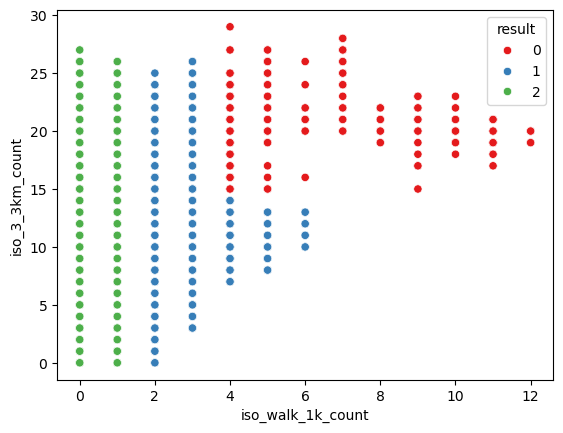

In [14]:
# Scatter plot with count of isochrone

sns.scatterplot(data=study_area, x='iso_walk_1k_count', y='iso_3_3km_count', hue='result', palette='Set1')